In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")


import codimar
import ELPH_utils


In [2]:
runs = ELPH_utils.load_runs(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax=200.npz')

# runs = runs[:100:1]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

1000 loaded with n_kmax = 200


runs[0] shape:  (200, 400)


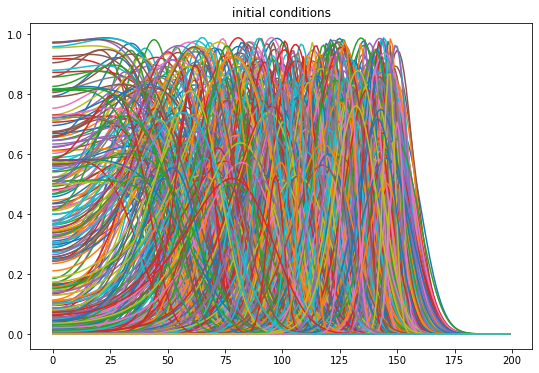

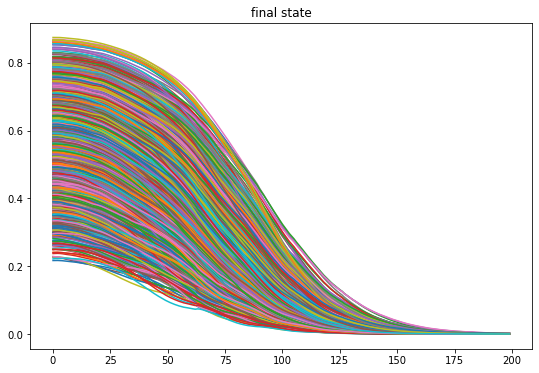

In [3]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()


for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('final state')
plt.show()

full_hist:  False
intercept:  True
standardize:  True
rdim:  20
prdim:  20
n_VAR_steps:  2
train shape:  (141, 399000)
target shape:  (20, 399000)
weights shape:  (141, 20)


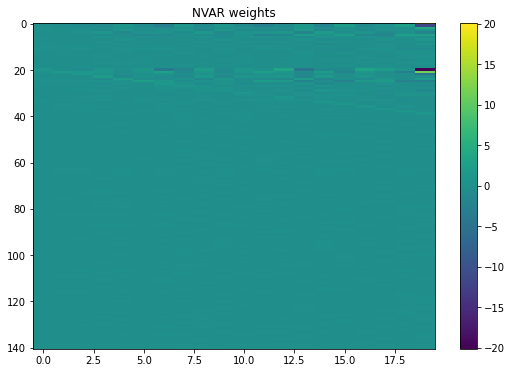

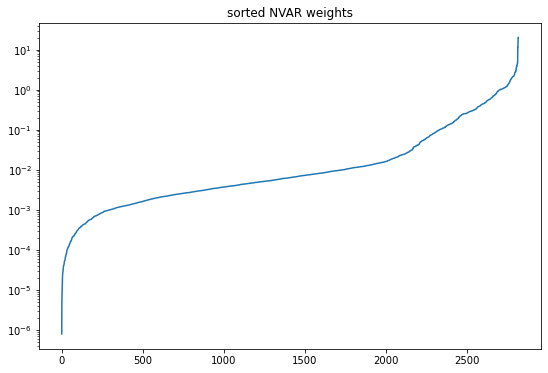

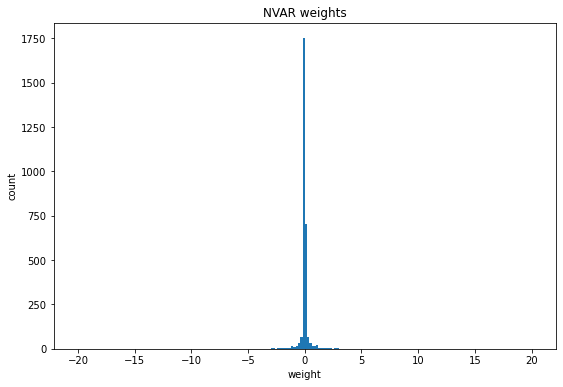

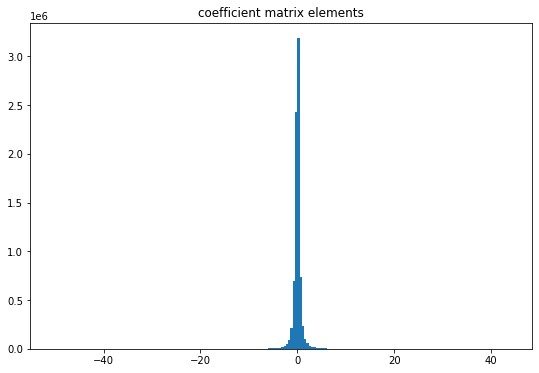

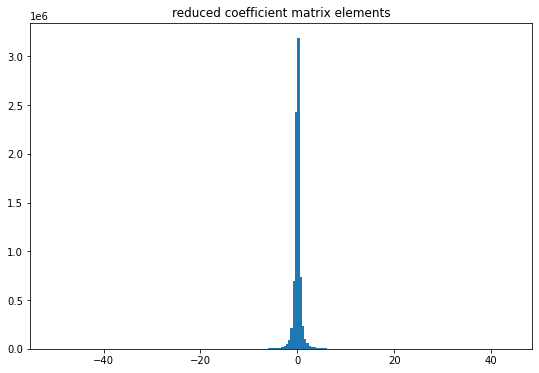

In [24]:
optimizer = codimar.optimizer.ridge(alpha=10.**-3.0)

# scaler = codimar.scaler.normalize_scaler(0.5)
scaler = codimar.scaler.standardize_scaler(1.0)

dim_reducer = codimar.dim_compressor.SVD()

def sigmoid(x):
    return 2.0/(1.0 + np.exp(-x)) -1.0

activation_function=np.tanh

ELM_transformer = codimar.transformer.ELM_features(ELM_nodes=100, activation_function=activation_function)

model = codimar.codimar(runs, n_VAR_steps=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=ELM_transformer)
model.train(rdim=20, prdim = 20)
model.print_status()

plt.imshow(model.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(model.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(model.w), bins=200)
plt.title('NVAR weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

plt.hist(np.ravel(model.coef_matrix), bins=200)
plt.title('coefficient matrix elements')
plt.show()

plt.hist(np.ravel(model.coef_matrix[:model.rdim]), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

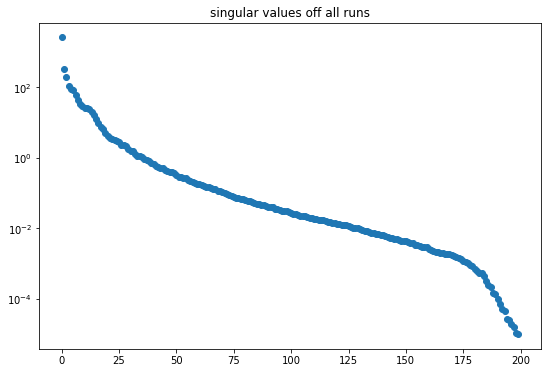

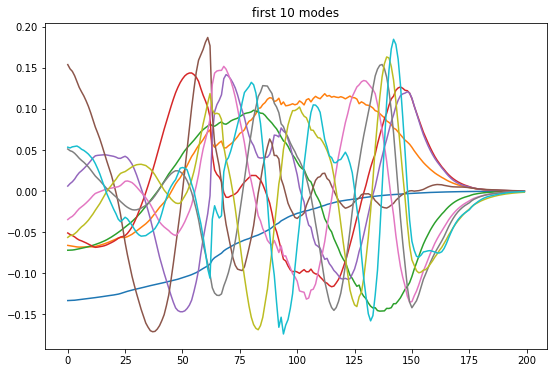

In [5]:
plt.semilogy(dim_reducer.S, 'o')
plt.title('singular values off all runs')
plt.show()

rdim = 10
for l in range(rdim):
  plt.plot(dim_reducer.U[:,l],  label='U_'+str(l))
plt.title('first ' + str(rdim) + ' modes')
plt.show()

In [1]:
optimizer = codimar.optimizer.ridge(alpha=10.**-3.857)

# scaler = codimar.scaler.normalize_scaler(0.5)
scaler = codimar.scaler.standardize_scaler(1.0)

dim_reducer = codimar.dim_compressor.SVD()
ELM_transformer = codimar.transformer.ELM_features(ELM_nodes=200, seed=107)

model = codimar.codimar(runs, n_VAR_steps=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=ELM_transformer)

train_kwargs = {'rdim':20, 'prdim':20}

scores = ELPH_utils.get_KFold_CV_scores(model, runs, folds=10, seed=817, norms=['std','max'], train_kwargs=train_kwargs)

print('std error: ', str(np.mean(scores[0])) + '+-' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + '+-' + str(np.std(scores[1])) )


NameError: name 'codimar' is not defined

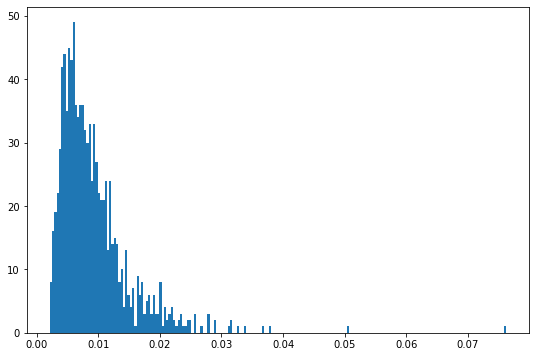

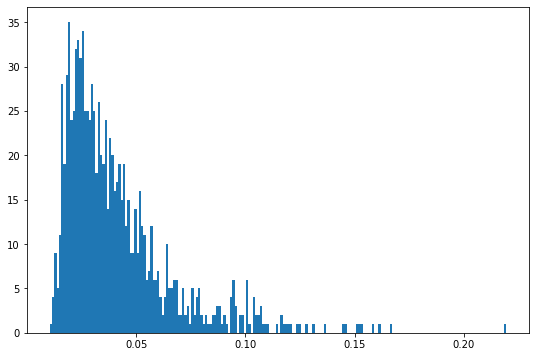

In [34]:
plt.hist(scores[0],bins=200)
plt.show()

plt.hist(scores[1],bins=200)
plt.show()

full_hist:  False
intercept:  True
standardize:  True
rdim:  20
prdim:  20
n_VAR_steps:  2
train shape:  (241, 398601)
target shape:  (20, 398601)
weights shape:  (241, 20)
std error:  0.002921061409184598
max error:  0.012792793301389372


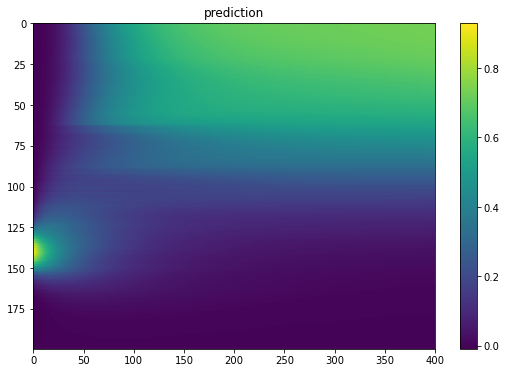

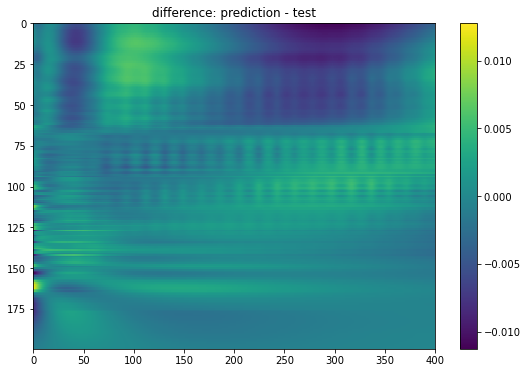

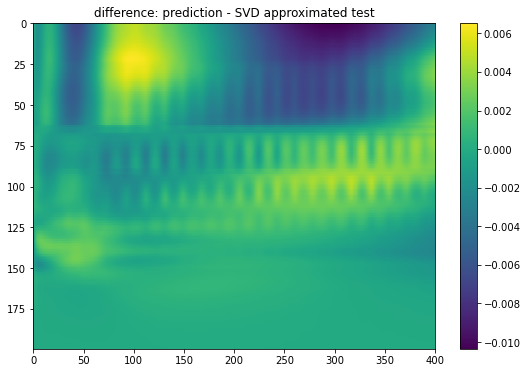

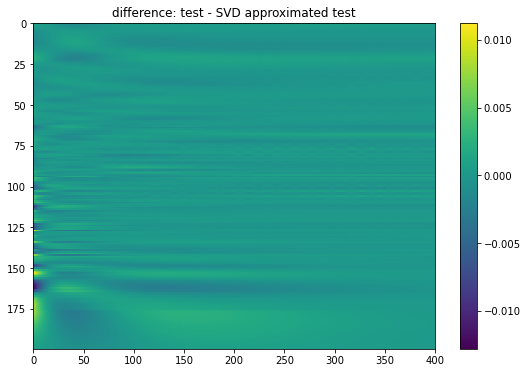

In [9]:
optimizer = codimar.optimizer.ridge(alpha=10.**-3.0)
scaler = codimar.scaler.normalize_scaler(0.5)
dim_reducer = codimar.dim_compressor.SVD()
ELM_transformer = codimar.transformer.ELM_features(ELM_nodes=200, seed=1)

model = codimar.codimar(runs, n_VAR_steps=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=ELM_transformer)

train_runs = runs[::1]
test_run = train_runs.pop(73)

model.load_runs(train_runs)
model.train(rdim=20, prdim = 20)

model.print_status()


pred = model.predict_single_run(test_run)


print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max error: ', model.get_error(test_run, pred, norm='max') )


xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()


test_run_SVDapprx = dim_reducer.U[:,:20] @ dim_reducer.U[:,:20].T @ test_run

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()


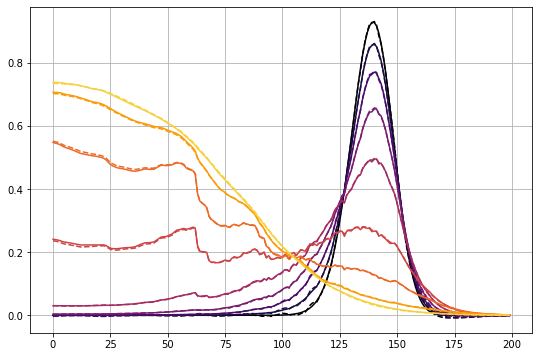

std error:  0.002921061409184598
max abs error:  0.012792793301389372


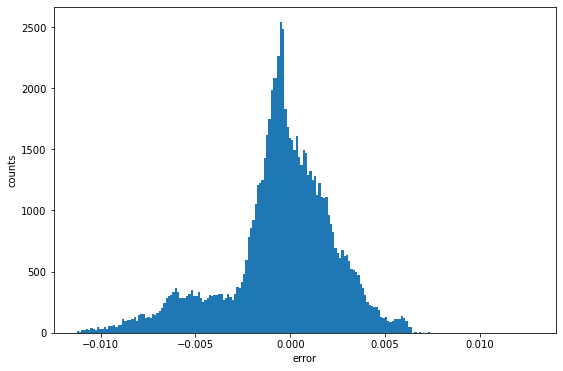

In [10]:
colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_run[:,tn], '-', c=colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=colors(k/len(tn_arr)))

plt.show()

print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max abs error: ', model.get_error(test_run, pred, norm='max') )

plt.hist(np.ravel(pred-test_run), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()

In [ ]:
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.ELM_features(ELM_nodes=100, activation_function=activation_function, seed=0)

def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    optimizer = ELPH_Optimizer.ridge(alpha=alpha)

    
    train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler, 'dim_reducer':dim_reducer, 'VAR_transformer':VAR_transformer }
    score_kwargs = {'norm':'max'}
    
    m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

# print(get_score(-3.4, 0.1))

from bayes_opt import BayesianOptimization
pbounds = {'aExp':[-5, -1], 'rel_scale':[0.1,1.0]}
optimizer = BayesianOptimization(f=get_score, pbounds=pbounds, random_state=817)

optimizer.maximize(init_points=5, n_iter=100)

In [ ]:
dim_reducer = ELPH_Dim_Reducer.SVD()
VAR_transformer = ELPH_VAR_Transformer.ELM_features(ELM_nodes=200, seed=0)

def get_score(aExp, rel_scale):
    alpha = 10.0**aExp
    
    scaler = ELPH_Scaler.normalize_scaler(rel_scale)
    optimizer = ELPH_Optimizer.ridge(alpha=alpha)

    train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler, 'dim_reducer':dim_reducer, 'VAR_transformer':VAR_transformer }
    score_kwargs = {'norm':'std'}
    
    m,s = ELPH_utils.get_KFold_CV_scores(model, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    
    r = -1.*m - 1.*np.std(s)
    if np.isnan(r):
        r = -10.0
    return r

scores = []

k = 1

for aExp in np.linspace(-5,-1,15):
    for rs in np.linspace(0.1,1.0,15):
        print(k)
        scores.append(get_score(aExp,rs))
        k += 1



In [ ]:


scrs = np.array(scores)
scrs = np.reshape(scrs,(15,15))


plt.imshow(-1.0*scrs, aspect='auto', origin='lower', vmin=0.00, vmax=0.01, extent=[0.1,1.0,-5,-1])
plt.colorbar()
plt.show()

